# Notes

In this example, we aim to delve into the features learned through our pretraining process, with a focus on identifying the most significant types of features. Our exploration will first cover cell-level features, followed by an analysis of geneset-level features.

In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [2]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672//data'

df_tpm = pd.read_pickle(os.path.join(data_path,  'TCGA.TPM.TABLE'))
df_label = pd.read_pickle(os.path.join(data_path, 'TCGA.PATIENT.PROCESSED.TABLE'))

mpath = './checkpoint/latest//pretrainer.pt'
# load the pretrained model as a feature extractor
pretrainer = loadconceptor(mpath)

In [3]:
genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

1019894

In [4]:
pretrainer.batch_correction

0.1

In [5]:
data_path = '/home/was966/Research/mims-conceptor/paper/00_data'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_tpm = df_tpm[pretrainer.feature_name]

df_tpm.shape, df_label.shape

((1133, 15672), (1133, 111))

In [6]:
# df_label.groupby(['cohort']).size()

In [7]:
df_label.cohort = df_label.cohort.apply(lambda x:x.split('_')[0])

# cs = df_label.groupby('cohort').size().astype(str)
# cs_map = pd.Series(cs.index + "(n=" + cs.values + ")", index=cs.index).to_dict()
# df_label.cohort = df_label.cohort.map(cs_map)

df_label.cohort = df_label.cancer_type + '_' + df_label.cohort

In [8]:
#df_label.cancer_type = df_label.cancer_type.map(lambda x:x.replace('TCGA-', ''))
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfcx.head()

,cancer_code,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Index,,,,,,,,,,,,,,,,,,,,,
IMVigor210-0257bb-ar-0257bbb,1,0.205851,2.155888,659.745279,20.704149,7.936608,0.000000,82.356025,6.818171,1.341996,...,19.827670,35.762746,3.052251,4.759638,23.932628,0.353733,53.545112,33.434797,63.913951,21.918333
IMVigor210-025b45-ar-025b45c,1,1.868506,0.000000,368.595425,7.356325,14.221725,0.012419,66.000702,16.410020,74.672523,...,21.562821,7.727498,2.840277,4.399035,10.118828,0.425108,30.963466,87.048508,50.694129,15.833533
IMVigor210-032c64-ar-032c642,1,0.074416,0.023730,194.673484,1.016972,58.998834,0.012352,105.698176,15.143666,0.028117,...,28.428787,29.953545,3.286946,4.307672,13.970757,1.582359,19.573847,94.128930,47.873491,10.933422
IMVigor210-0571f1-ar-0571f17,1,2.306056,0.000000,325.709796,18.747406,10.965047,0.018950,76.854569,7.491749,0.043138,...,23.462814,18.647978,5.777748,5.938934,12.687338,1.001439,20.971129,50.101555,78.684380,14.659834
IMVigor210-065890-ar-0658907,1,0.000000,0.024102,182.904400,23.246839,3.457102,0.000000,66.561993,14.851419,120.742181,...,30.468925,16.782164,4.356220,7.165276,17.453367,0.552250,33.347260,20.544651,41.852786,18.699320


In [9]:
# [dfcx.cancer_code==25]

In [10]:
dfg, dfc = pretrainer.project(dfcx,  batch_size= 128) #dfcx[dfcx.cancer_code==25]
dfc.shape

dfo = dfc

# scols = [ 'Exhausted_Tcell', 'OS_effect', 'TMB'] #, 'CD4_Tcell'
# dfo= dfo[dfo.index.map(lambda x:x.split('$$')[-1] in scols)]

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS

mp = UMAP(n_components=2 , min_dist=0.8, n_neighbors = 30, verbose=1) #, min_dist=1, , min_dist=0.8
#mp = UMAP(n_components=2)
c2d = mp.fit_transform(dfo)

100%|##########| 9/9 [00:03<00:00,  2.42it/s]


UMAP(min_dist=0.8, n_neighbors=30, verbose=1)
Mon Mar  4 18:02:02 2024 Construct fuzzy simplicial set
Mon Mar  4 18:02:02 2024 Finding Nearest Neighbors
Mon Mar  4 18:02:02 2024 Building RP forest with 16 trees
Mon Mar  4 18:02:06 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Mon Mar  4 18:02:20 2024 Finished Nearest Neighbor Search
Mon Mar  4 18:02:24 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Mar  4 18:03:17 2024 Finished embedding


/tmp/ipykernel_137500/2371223915.py:10: UserWarning: 
The palette list has fewer values (32) than needed (45) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = df2d, x = 'x', y= 'y', hue = 'c',  alpha = 0.8, linewidth=0.0, sizes = 0.001,


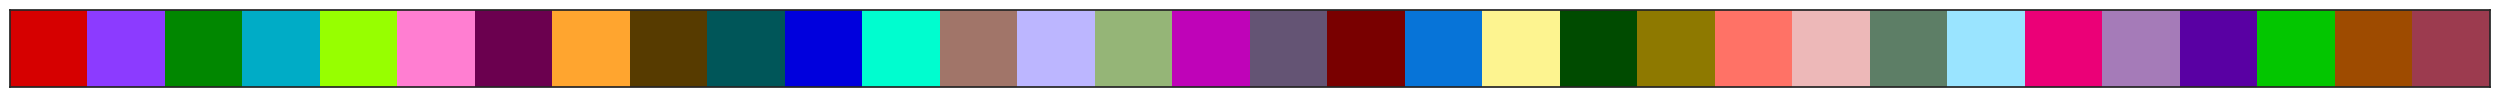

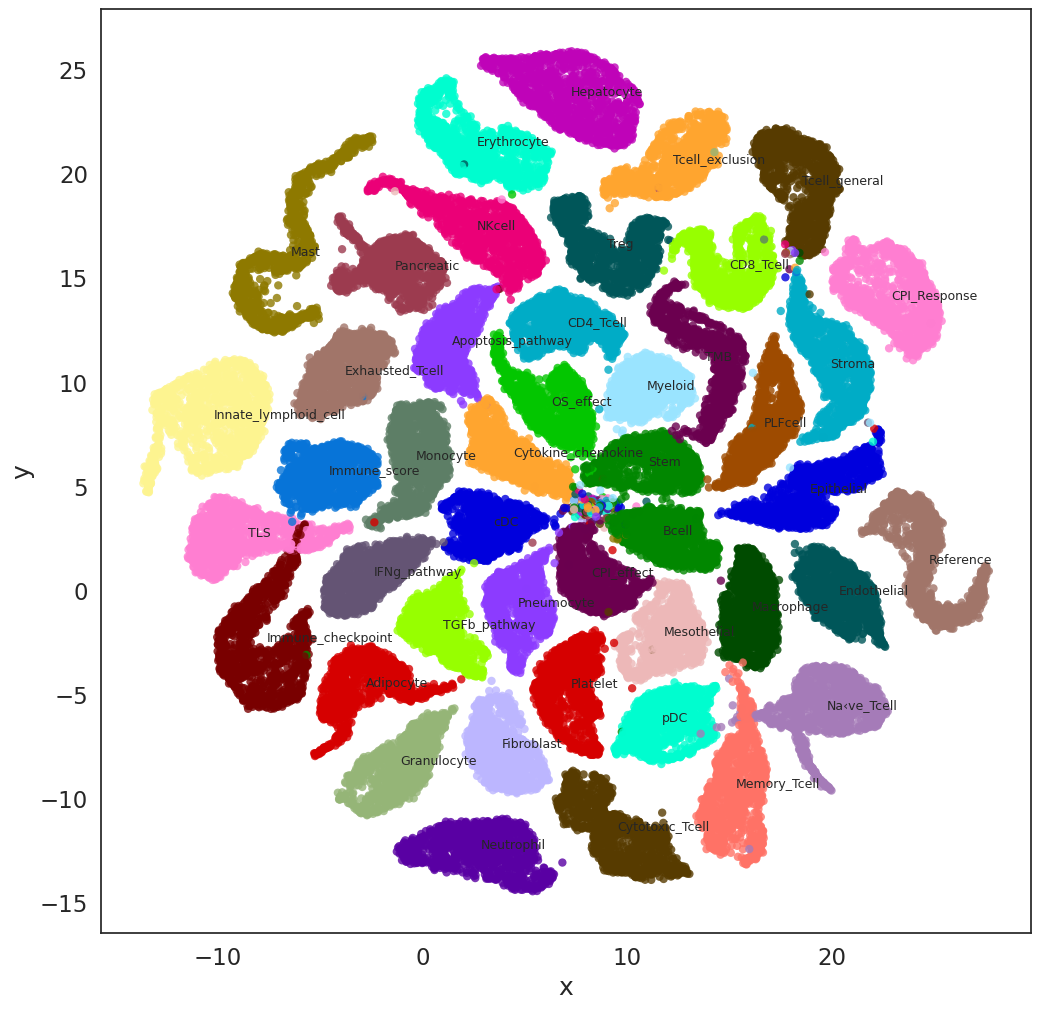

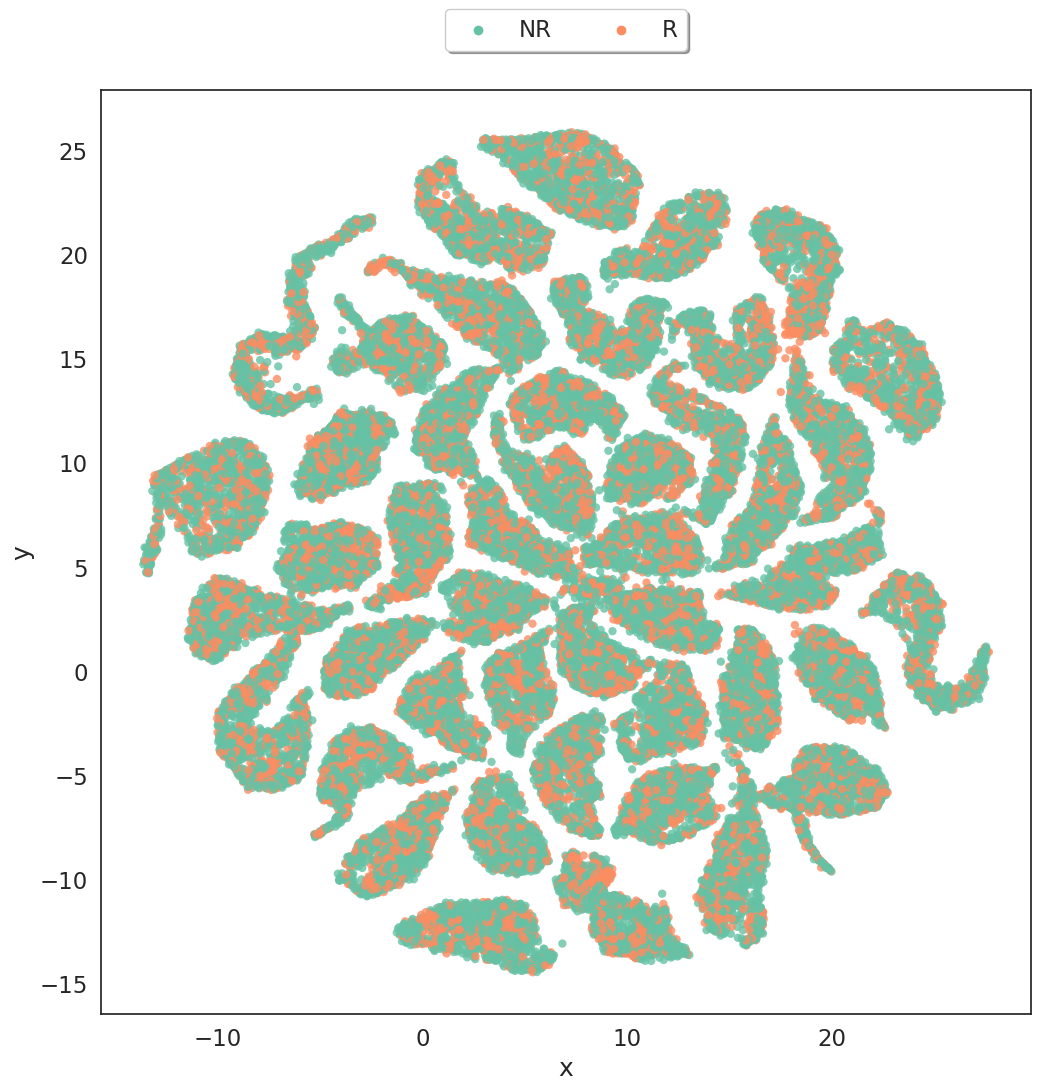

In [11]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors= len(dfo.columns))
sns.palplot(palette)

df2d  = pd.DataFrame(c2d, index=dfo.index, columns = ['x', 'y'])
df2d['c'] = df2d.index.map(lambda x:x.split('$$')[1])


fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df2d, x = 'x', y= 'y', hue = 'c',  alpha = 0.8, linewidth=0.0, sizes = 0.001,
                palette=palette, ax=ax, legend=False)

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6),
#           ncol=3, fancybox=True, shadow=True)

mean = df2d.groupby('c').mean()
for name in mean.index:
    s = mean.loc[name]
    ax.text(s.x, s.y, name,  fontdict={'fontsize':9})


df2d  = pd.DataFrame(c2d, index=dfo.index, columns = ['x', 'y'])
df2d['pid'] = df2d.index.map(lambda x:x.split('$$')[0])
df2d['l'] = df2d.pid.map(df_label.response_label)
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data = df2d, x = 'x', y= 'y', hue = 'l',  alpha = 0.8, linewidth=0.0, sizes = 0.001, 
                palette='Set2', ax=ax)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)


# df2d  = pd.DataFrame(c2d, index=dfo.index, columns = ['x', 'y'])
# df2d['pid'] = df2d.index.map(lambda x:x.split('$$')[0])
# df2d['l'] = df2d.pid.map(df_label.tmb)
# fig, ax = plt.subplots(figsize=(12, 12))
# sns.scatterplot(data = df2d, x = 'x', y= 'y', hue = 'l',  alpha = 0.8, linewidth=0.0, sizes = 0.001,
#                 palette='Set2', ax=ax)

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#           ncol=3, fancybox=True, shadow=True)

In [12]:
dfgeneset, dfcelltype = pretrainer.extract(dfcx,  batch_size= 32)

100%|##########| 36/36 [00:02<00:00, 14.87it/s]


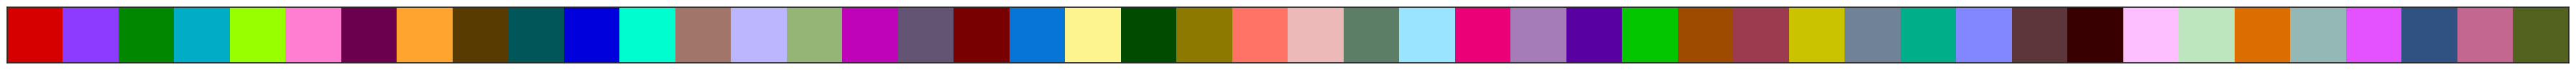

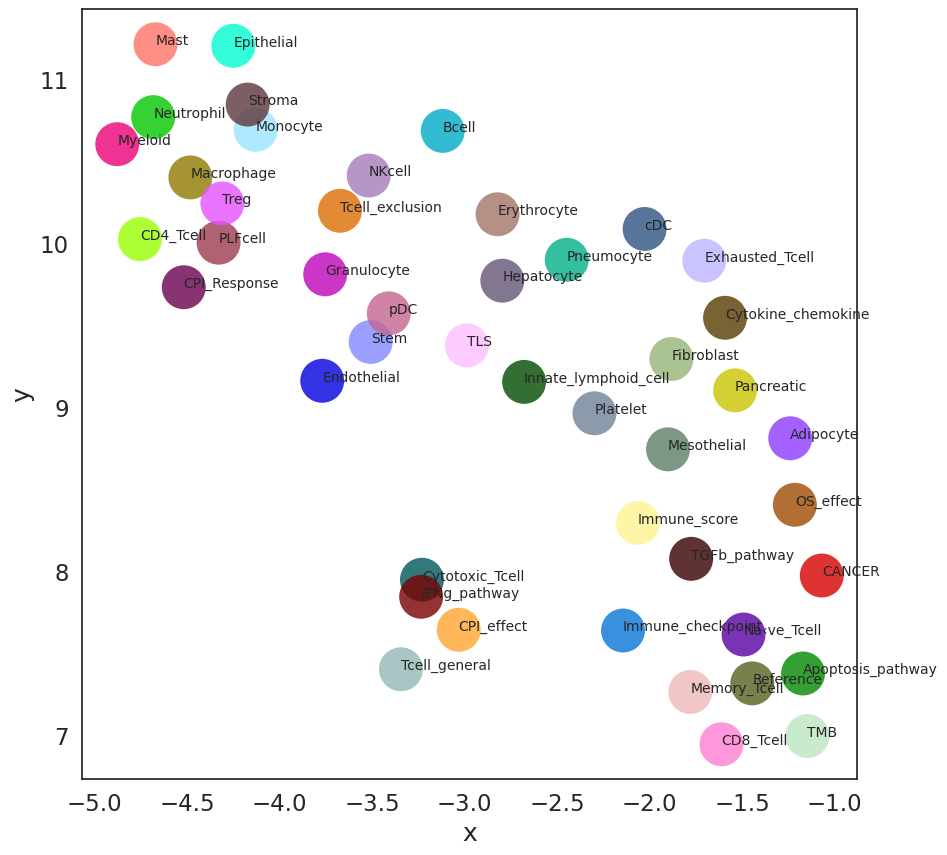

In [13]:

palette = sns.color_palette(cc.glasbey, n_colors=len(dfcelltype.columns))
sns.palplot(palette)

mp = UMAP(n_components = 2)
c2d = mp.fit_transform(dfcelltype.T)
df2d  = pd.DataFrame(c2d, index=dfcelltype.columns, columns = ['x', 'y'])
df2d['c'] = df2d.index
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = df2d, x = 'x', y= 'y', hue = 'c',  alpha = 0.8, linewidth=0.0, s = 1000,
                palette=palette, ax=ax, legend=False)

for name in df2d.index:
    s = df2d.loc[name]
    ax.text(s.x, s.y, name,  fontdict={'fontsize':10})

In [14]:
dfcelltype

,CANCER,Adipocyte,Apoptosis_pathway,Bcell,CD4_Tcell,CD8_Tcell,CPI_Response,CPI_effect,Cytokine_chemokine,Cytotoxic_Tcell,...,Stroma,TGFb_pathway,TLS,TMB,Tcell_exclusion,Tcell_general,Treg,cDC,pDC,Reference
Index,,,,,,,,,,,,,,,,,,,,,
IMVigor210-0257bb-ar-0257bbb,2.231586,0.095630,0.184865,-0.101285,0.000709,0.111215,-0.095574,-0.108335,0.007202,-0.026011,...,-0.117547,-0.044376,-0.187580,0.247796,-0.081353,-0.185191,-0.120832,-0.054601,-0.013504,0.954684
IMVigor210-025b45-ar-025b45c,2.231571,0.027646,0.168403,-0.095822,-0.164405,0.076903,-0.115808,-0.093869,0.062431,-0.227304,...,-0.147676,0.150748,-0.140836,0.168329,-0.090209,-0.228629,-0.136457,-0.041072,-0.113345,0.962315
IMVigor210-032c64-ar-032c642,2.231653,-0.018395,0.208292,-0.128894,0.033699,0.095141,-0.164183,0.134724,-0.143532,0.236043,...,-0.076602,0.044724,-0.162292,0.293963,-0.065497,0.049252,-0.113452,0.102485,0.089825,0.959041
IMVigor210-0571f1-ar-0571f17,2.231629,-0.080947,0.082151,0.068193,-0.203625,0.238796,-0.171105,0.152739,-0.045930,0.200654,...,-0.097851,-0.039122,0.399589,0.231509,-0.107365,0.472308,-0.066194,-0.090312,0.038006,0.958613
IMVigor210-065890-ar-0658907,2.231627,0.024996,0.252321,-0.137305,0.008070,0.087979,-0.103647,-0.016986,0.047156,0.061902,...,-0.040036,-0.115632,-0.234322,0.233928,-0.095498,-0.064346,-0.114739,-0.027730,-0.092800,0.953355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kim_NatMed_2018-p664-ar-026,1.627479,0.068577,0.041009,-0.217709,0.077308,0.030163,0.081621,-0.118119,0.002689,-0.080737,...,-0.053680,-0.087933,-0.132600,0.054451,-0.041023,-0.102565,0.023068,0.005668,0.064366,0.954492
Kim_NatMed_2018-p666-ar-029,1.627510,-0.105246,-0.083568,-0.185884,0.283744,0.010876,0.073165,-0.110530,-0.090282,-0.191312,...,-0.085995,0.019262,-0.073332,0.060165,0.007549,0.051668,-0.015393,-0.256994,0.096671,0.955504
Kim_NatMed_2018-p667-ar-030,1.627469,-0.094871,0.023387,-0.079644,0.053851,0.020817,-0.026282,-0.123075,-0.075198,-0.158911,...,-0.078045,0.056654,-0.045822,0.017424,-0.015716,-0.150744,0.038974,-0.041215,-0.061152,0.953556


In [15]:
label = df_label['response_label']
cohort = df_label['cohort']
cancer = df_label['cancer_type']

In [16]:
import scipy.stats as stats
# dfp

Text(233.25, 0.5, 'Cohort')

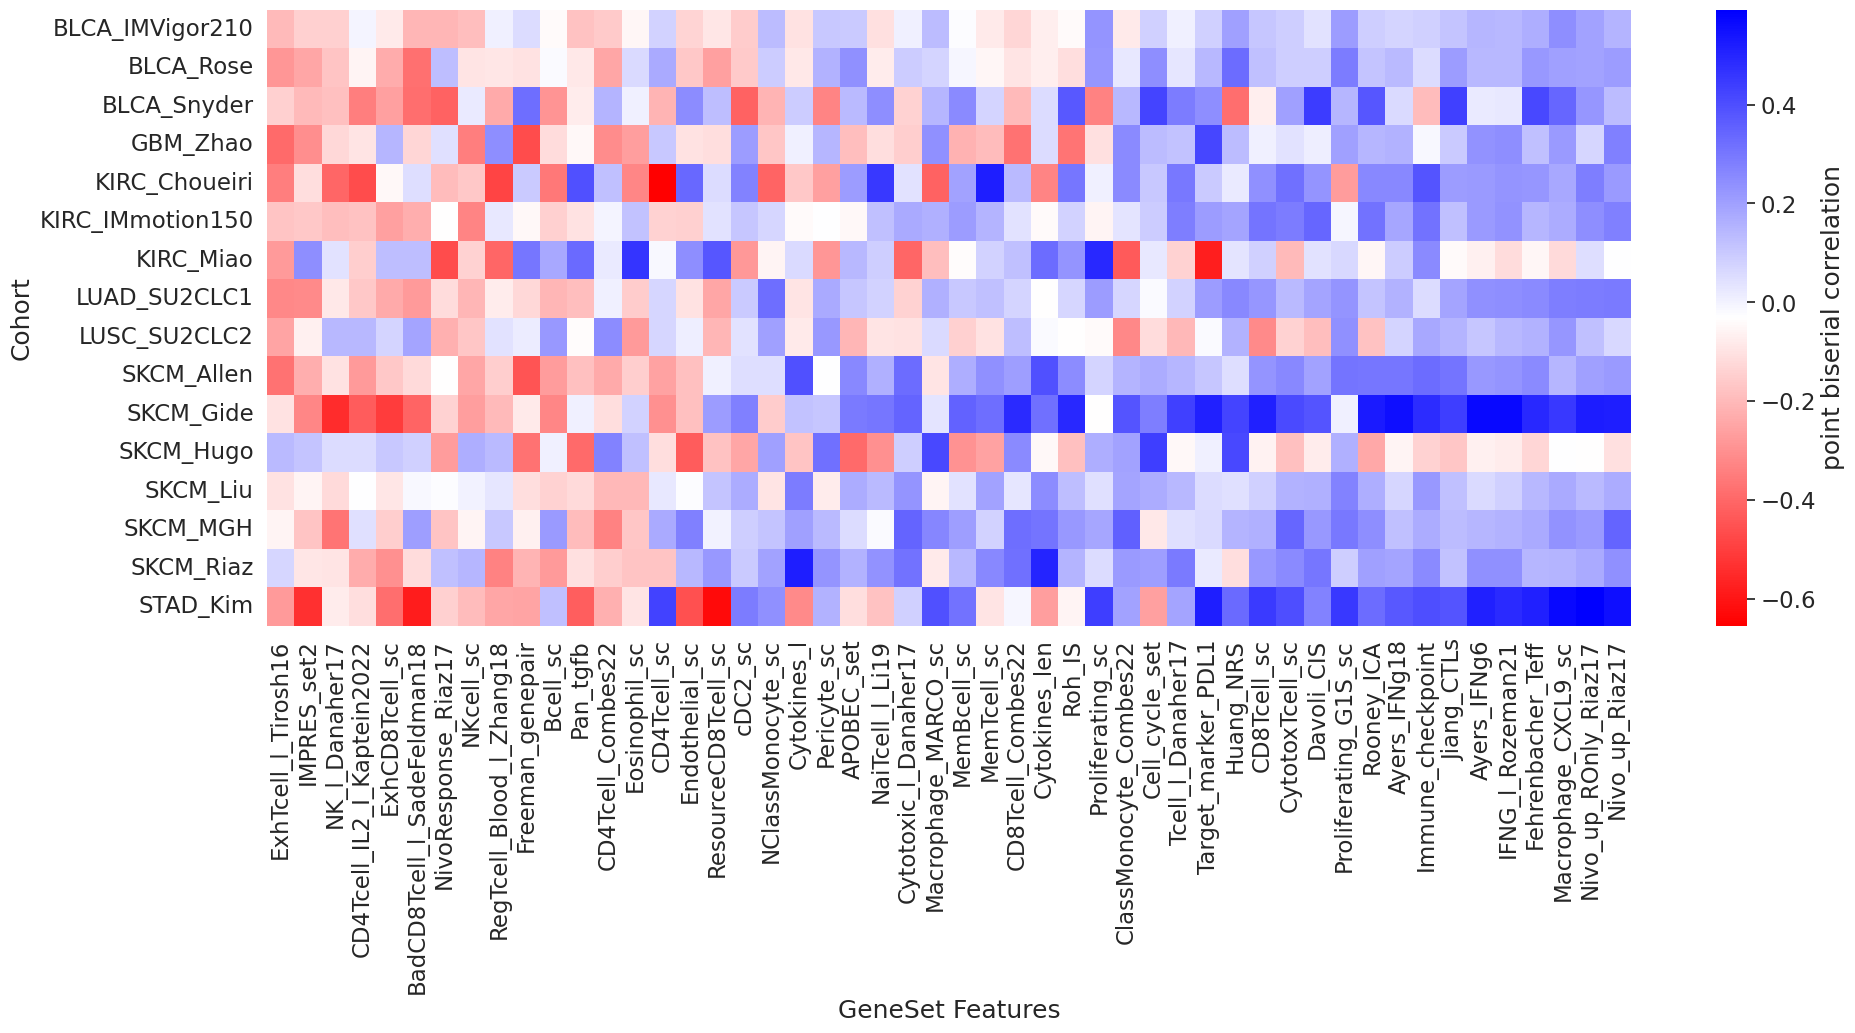

In [17]:
dfp = dfgeneset.join(label).join(cohort)
res= []
for f in dfgeneset.columns:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 
                                                                                        'NR':0}), 
                                                                  x[f])[0])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
selected_geneset = pcc.abs().mean().sort_values().tail(50).index
pcc = pcc[selected_geneset]


pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[cohort.unique()]


fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(pcc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'})

# groups = df_label[['cancer_type', 'cohort']].drop_duplicates().groupby('cancer_type').cohort.apply(lambda x:x.tolist()).to_dict()
# annotate_yranges(groups, ax =ax)
  
ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

Text(233.25, 0.5, 'Cohort')

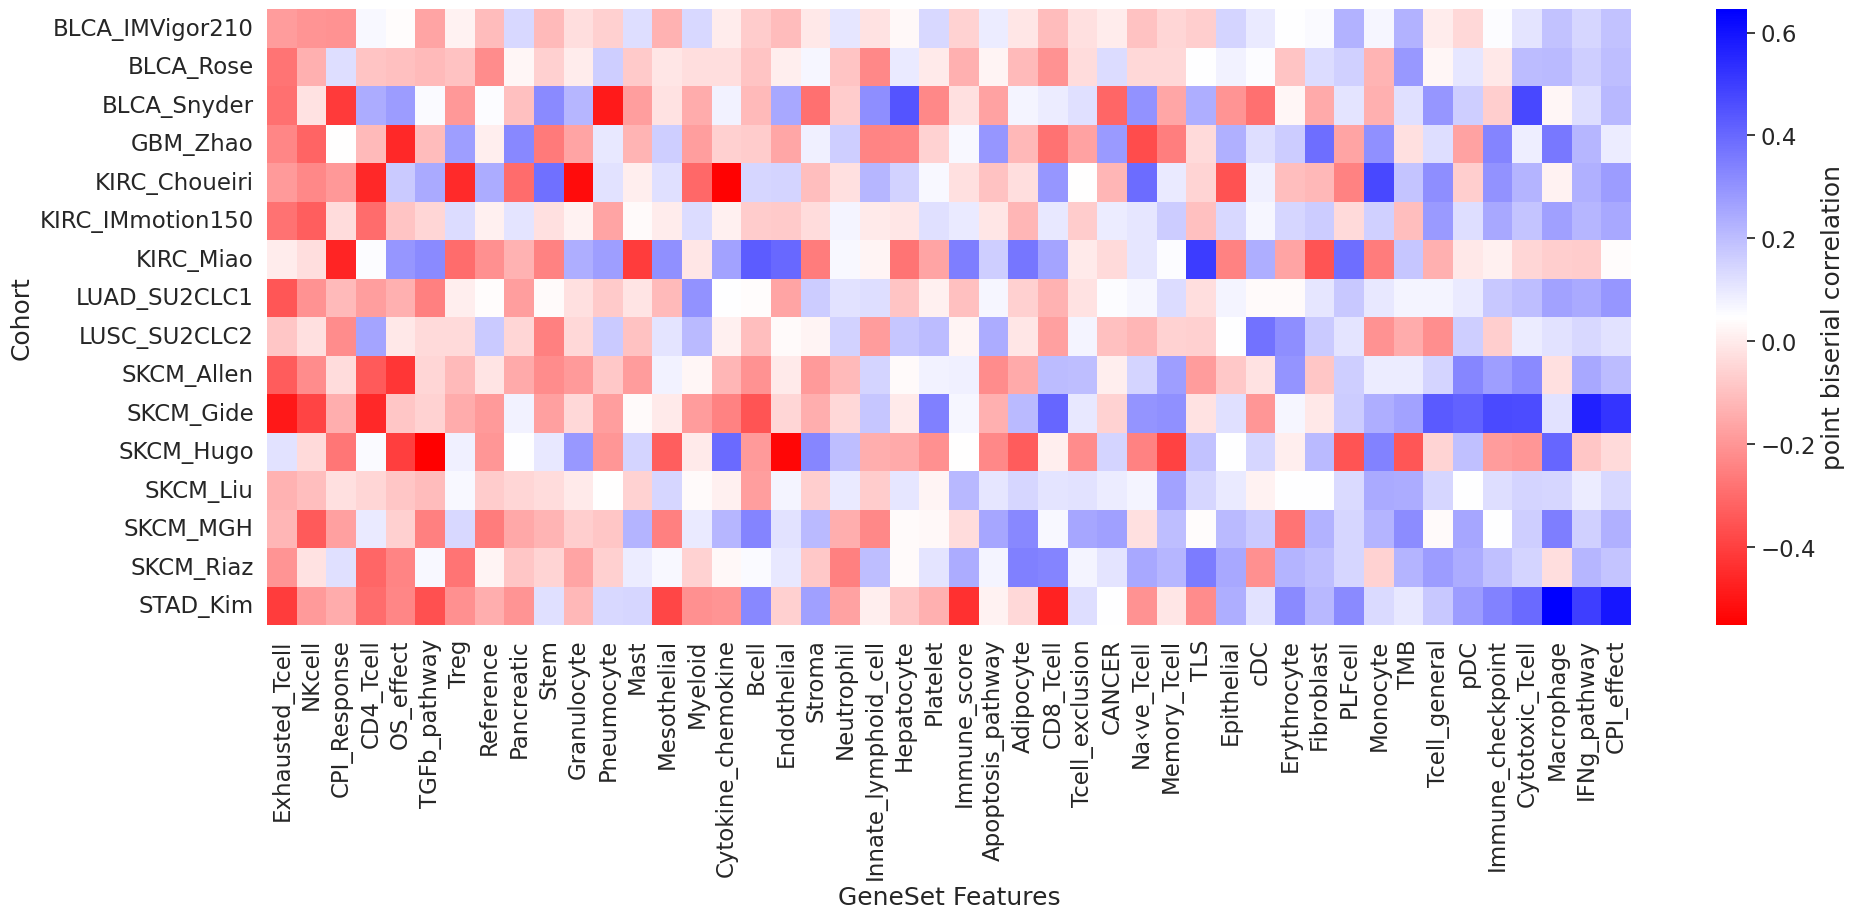

In [18]:
dfp = dfcelltype.join(label).join(cohort)
res= []
for f in dfcelltype.columns:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 
                                                                                        'NR':0}), 
                                                                  x[f])[0])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
selected_geneset = pcc.abs().mean().sort_values().tail(50).index
pcc = pcc[selected_geneset]

pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[cohort.unique()]

fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(pcc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'},) # vmin=-0.4, vmax=0.4

# groups = df_label[['cancer_type', 'cohort']].drop_duplicates().groupby('cancer_type').cohort.apply(lambda x:x.tolist()).to_dict()
# annotate_yranges(groups, ax =ax)

ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

In [19]:
pretrainer.batch_correction

0.1

In [20]:
#pretrainer.model.latentprojector
pcc.columns

Index(['Exhausted_Tcell', 'NKcell', 'CPI_Response', 'CD4_Tcell', 'OS_effect',
       'TGFb_pathway', 'Treg', 'Reference', 'Pancreatic', 'Stem',
       'Granulocyte', 'Pneumocyte', 'Mast', 'Mesothelial', 'Myeloid',
       'Cytokine_chemokine', 'Bcell', 'Endothelial', 'Stroma', 'Neutrophil',
       'Innate_lymphoid_cell', 'Hepatocyte', 'Platelet', 'Immune_score',
       'Apoptosis_pathway', 'Adipocyte', 'CD8_Tcell', 'Tcell_exclusion',
       'CANCER', 'Na‹ve_Tcell', 'Memory_Tcell', 'TLS', 'Epithelial', 'cDC',
       'Erythrocyte', 'Fibroblast', 'PLFcell', 'Monocyte', 'TMB',
       'Tcell_general', 'pDC', 'Immune_checkpoint', 'Cytotoxic_Tcell',
       'Macrophage', 'IFNg_pathway', 'CPI_effect'],
      dtype='object')

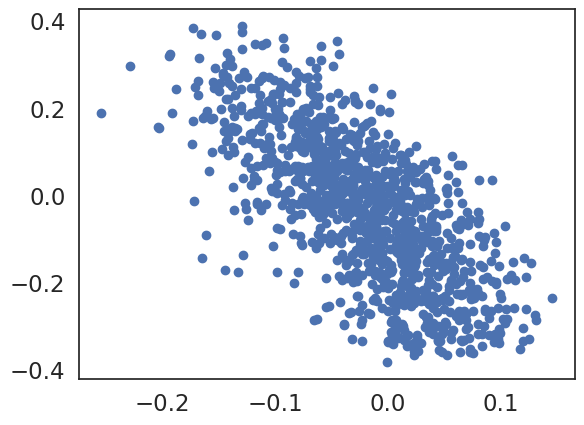

In [21]:
plt.scatter(dfp.Exhausted_Tcell, dfp.Cytotoxic_Tcell)

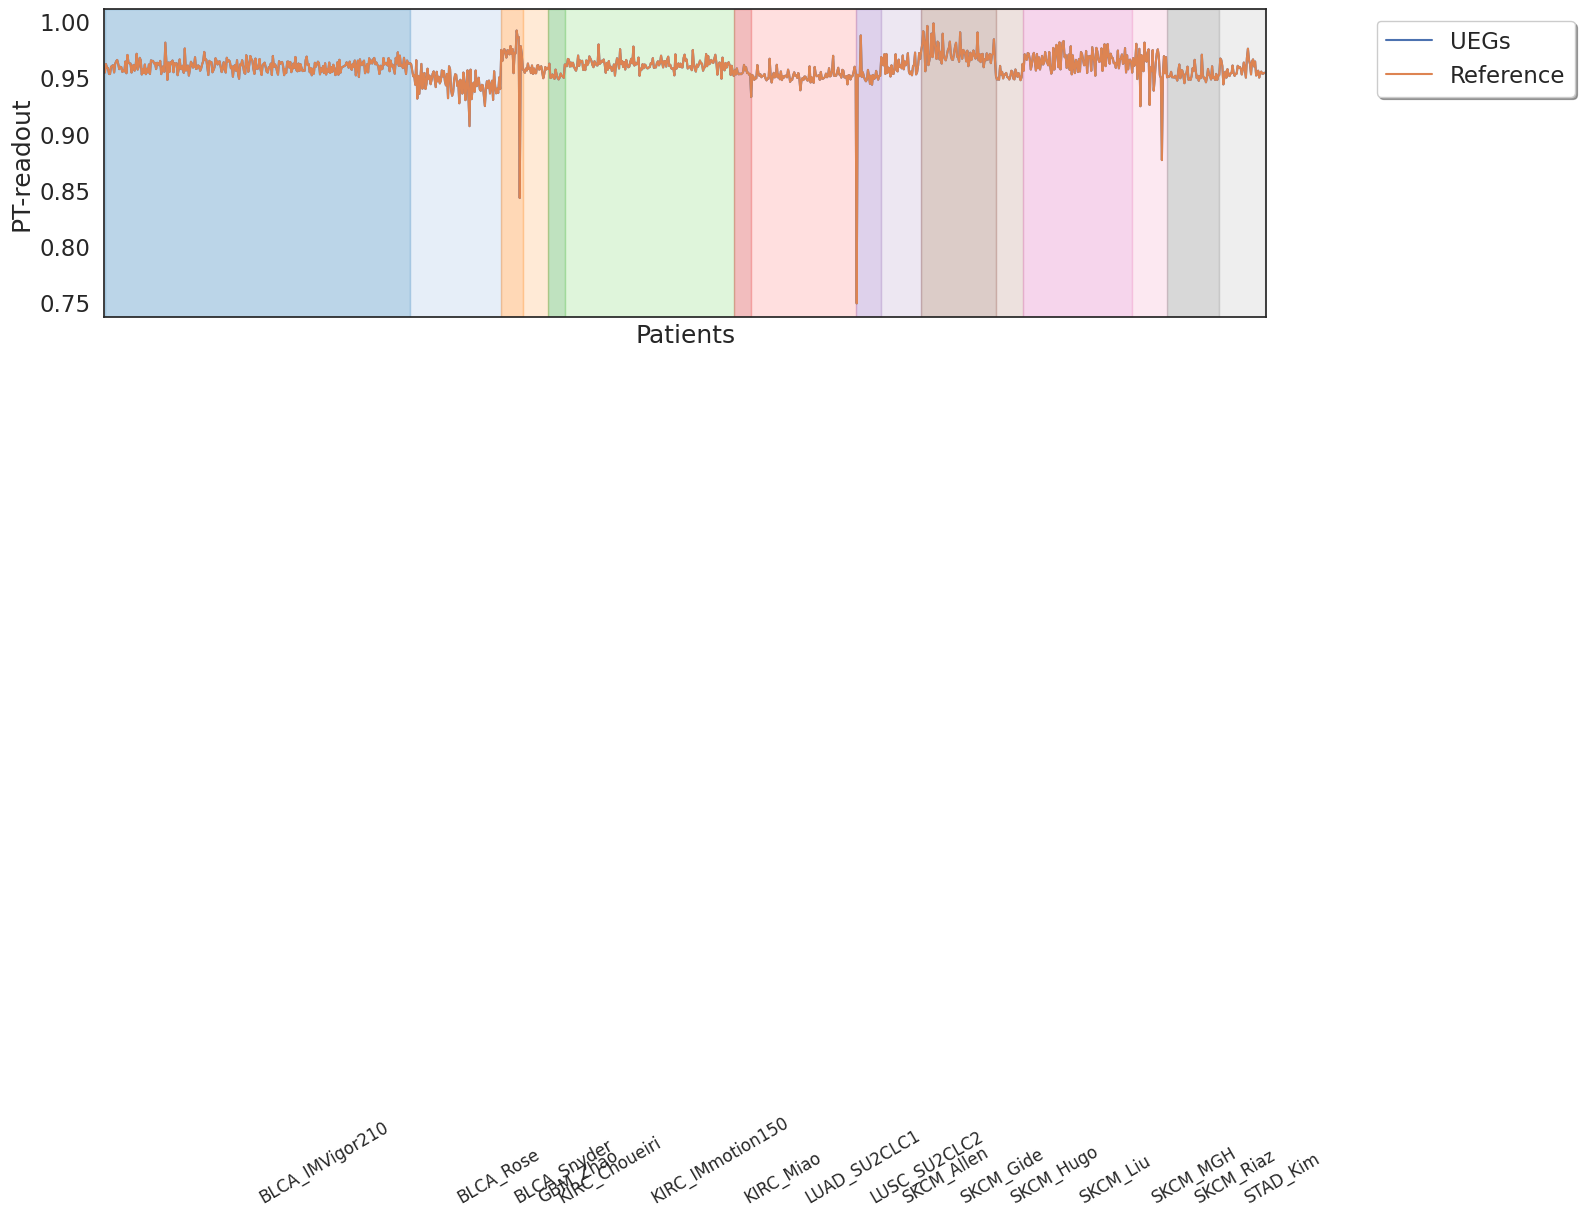

In [22]:
data = dfgeneset[['UEGs']].join(cohort)
data = data.join(dfcelltype['Reference'])
data = data.set_index('cohort')

fig, ax = plt.subplots(figsize=(15,4))

g = data.plot(ax=ax)

#g = sns.lineplot(data=df, x="index", y=y, )
df = data.reset_index()

cohort_color = sns.color_palette('tab20', len(df.cohort.unique()))
cohort_color.as_hex()
overlay = dict(zip(df.cohort.unique(), cohort_color.as_hex()))

for cohort_name in df.cohort.unique():
    tmp = df[df.cohort == cohort_name]
    v = overlay.get(cohort_name)
    g.axvspan(min(tmp.index), max(tmp.index)+1, color=v, alpha=0.3)
    g.text(((min(tmp.index)+max(tmp.index)+1) / 2)-1, -0.05,
           '{}'.format(tmp.cohort.unique()[0]), rotation = 30, 
           ha = 'left', fontsize=12)



ax.set_xlabel('Patients')
ax.set_xlim(-1, len(df)+1)
ax.set_ylabel('PT-readout')

ax.set_xticks([])
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.0),
          fancybox=True, shadow=True, ncol=1)
#ax.axhspan(ymin = -1, ymax=-0.4, xmin=0, xmax=0.1, alpha=.5)

/tmp/ipykernel_137500/4186096563.py:37: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = data, x = x, y = y2,
/tmp/ipykernel_137500/4186096563.py:40: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = data, x = x, y = y1,


desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:7.744e-09 U_stat=5.890e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.584e-07 U_stat=5.184e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:4.412e-17 U_stat=3.962e+03
desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:1.249e-11 U_stat=1.562e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:7.721e-11 U_stat=1.417e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:3.425e-18 U_stat=2.520e+02


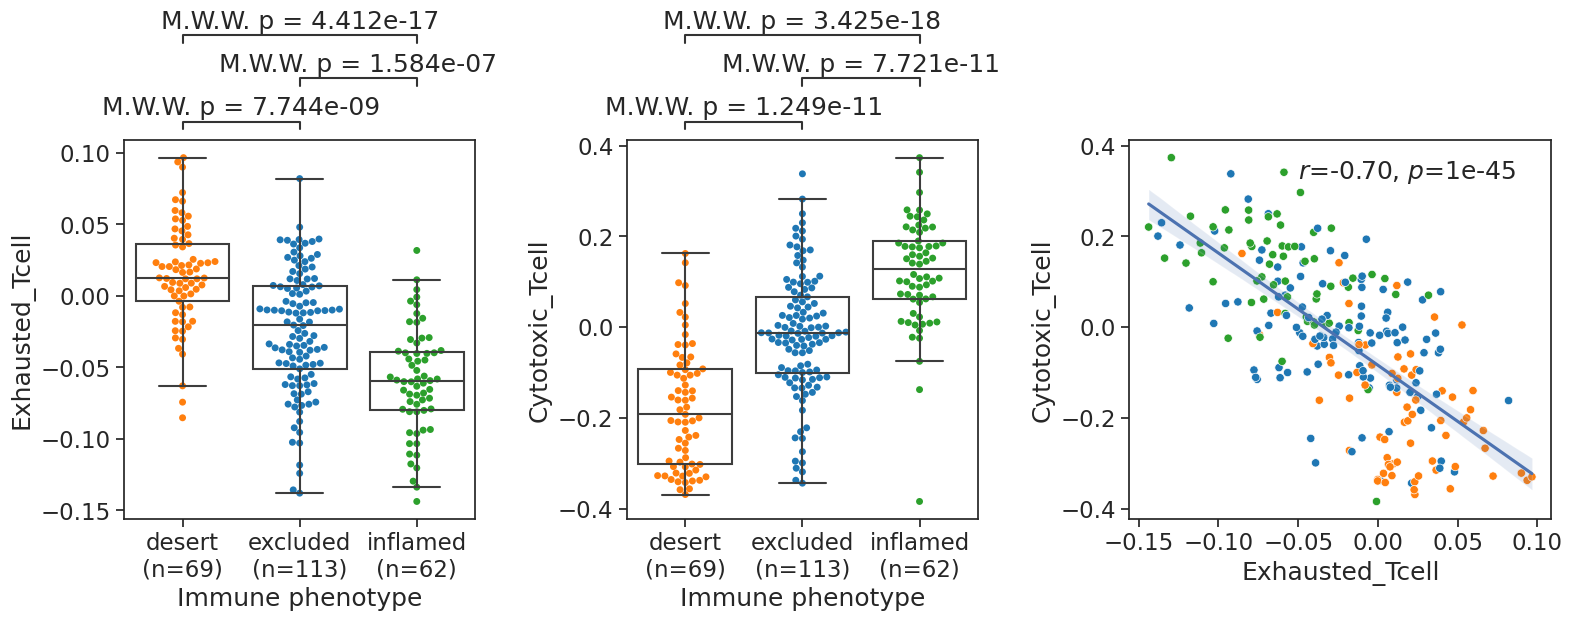

In [23]:
IMVigor210 = df_label[df_label.cohort == 'BLCA_IMVigor210']

x = 'Immune phenotype'
y1 = 'Exhausted_Tcell'
y2 = 'Cytotoxic_Tcell'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='full', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='full',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    
fig.tight_layout()

<Axes: xlabel='log2TMB', ylabel='TMB'>

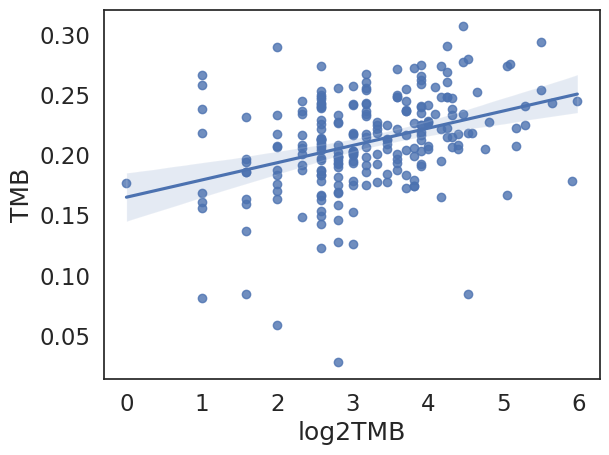

In [24]:
mycohort = 'BLCA_IMVigor210'
data2 = df_label[df_label.cohort == mycohort]
data2 = data2[['TMB (FMOne mutation burden per MB)']].join(dfcelltype[['TMB']]).dropna()
data2['log2TMB'] = np.log2(data2['TMB (FMOne mutation burden per MB)']+1)
#sns.jointplot(data=data2, x="log2TMB", y="TMB", kind="reg")
data2['cohort'] = mycohort

mycohort = 'BLCA_Rose'
data3 = df_label[df_label.cohort.isin([mycohort])]
data3 = data3[['TMB']].rename(columns={'TMB':'TMB_true'}).join(dfcelltype[['TMB']]).dropna()
data3['log2TMB'] = np.log2( data3['TMB_true']+1)
data3['cohort'] = mycohort

mycohort = 'SKCM_Liu'
data4 = df_label[df_label.cohort == mycohort]
data4 = data4[['log2_tmb.wang']].join(dfcelltype[['TMB']]).dropna()
data4['log2TMB'] = data4['log2_tmb.wang']
data4['cohort'] = mycohort


mycohort = 'SKCM_Riaz'
data5 = df_label[df_label.cohort == mycohort]
data5 = data5[['log2_tmb.wang']].join(dfcelltype[['TMB']]).dropna()
data5['log2TMB'] = data5['log2_tmb.wang']
data5['cohort'] = mycohort


data = data2._append(data3)._append(data4)._append(data5)
#fig, ax = plt.subplots(figsize=(8, 8))

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.regplot(data=data2, x="log2TMB", y="TMB")
# fig.tight_layout()

In [25]:
data2.corr()

/tmp/ipykernel_137500/1981098430.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data2.corr()


,TMB (FMOne mutation burden per MB),TMB,log2TMB
TMB (FMOne mutation burden per MB),1.000000,0.298332,0.884293
TMB,0.298332,1.000000,0.357731
log2TMB,0.884293,0.357731,1.000000


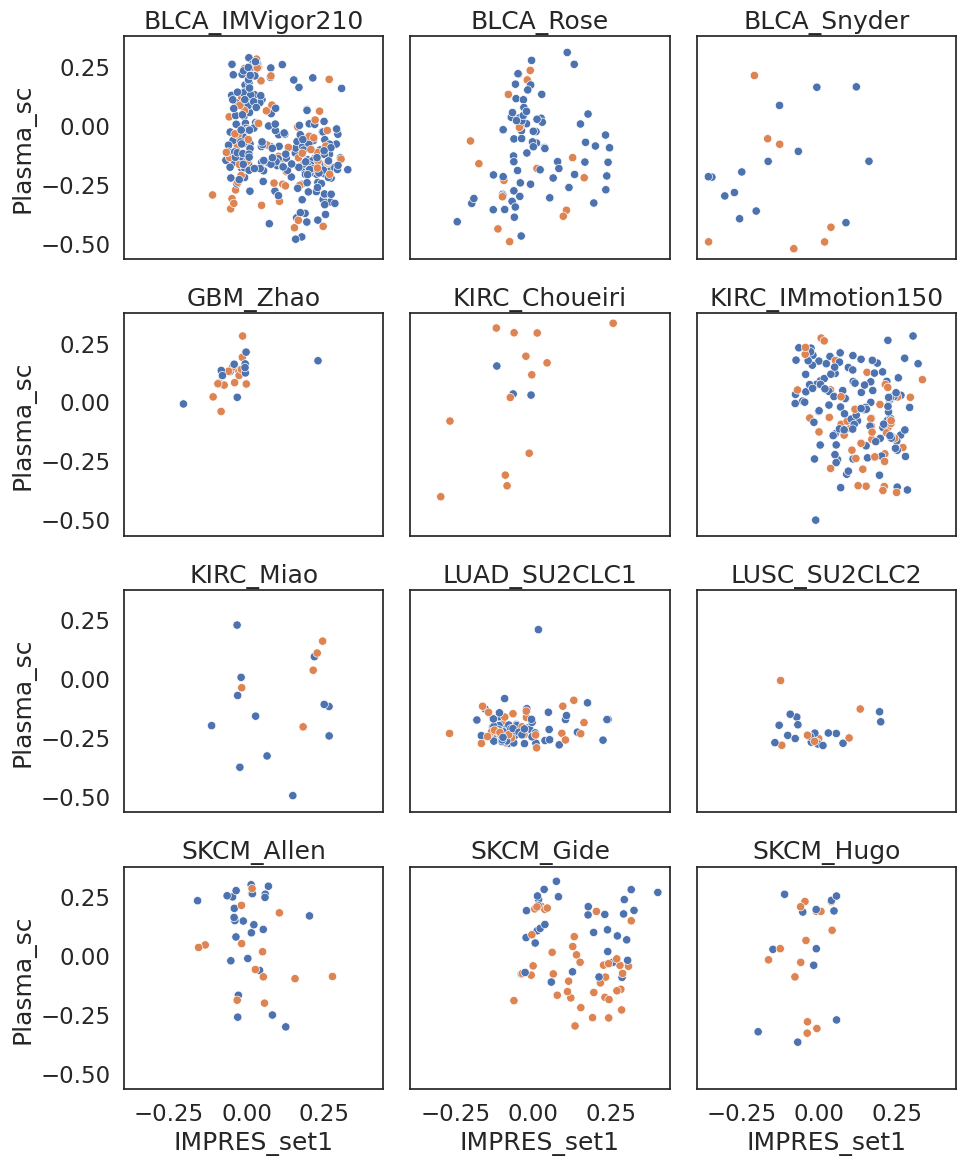

In [26]:
x = 'IMPRES_set1'
y = 'Plasma_sc'
hue = 'response_label'
dff = dfgeneset[[x,y]]

dfp2 = dff.join(label).join(cohort)

num_figs = len(dfp2.cohort.unique())


fig, axes = plt.subplots(nrows=4, ncols = 3, figsize=(10, 12),
                         sharex=True,
                         sharey=True,)

from itertools import chain
axes = list(chain(*axes))
gps = dfp2.groupby('cohort')

for ax, g in zip(axes, gps):
    group, data = g
    sns.scatterplot(data = data,  x = x, y=y, hue=hue, ax=ax, legend=False)
    ax.set_title(group)

fig.tight_layout()

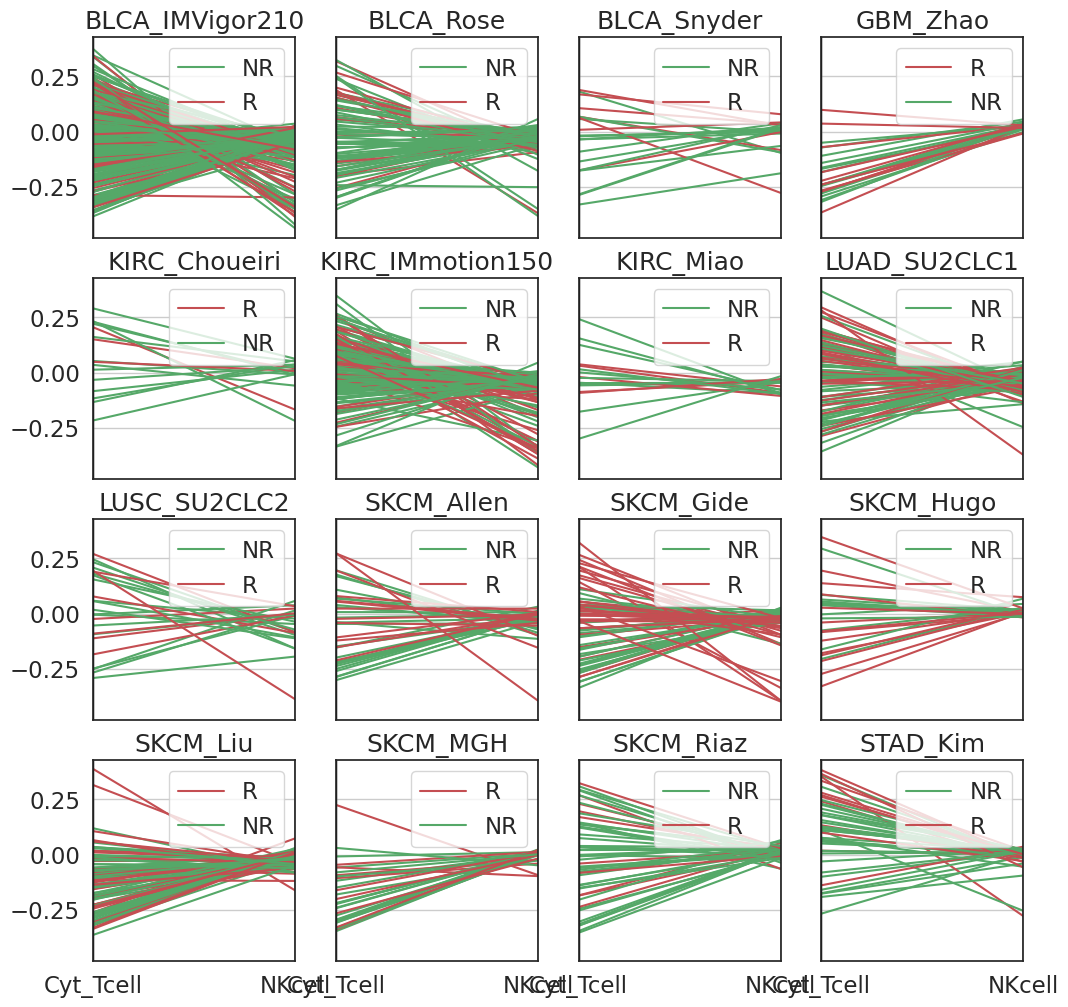

In [27]:
dff = dfcelltype[['Cytotoxic_Tcell', 'NKcell', ]].rename(columns={'Cytotoxic_Tcell':'Cyt_Tcell'})
dfp2 = dff.join(label).join(cohort)

fig, axes = plt.subplots(nrows=4, ncols = 4, figsize=(12, 12),
                         sharex=True,
                         sharey=True,)

from itertools import chain
axes = list(chain(*axes))
gps = dfp2.groupby('cohort')

for ax, g in zip(axes, gps):
    group, data = g
    pd.plotting.parallel_coordinates(data, 'response_label', ax=ax,
                                     cols = dff.columns, sort_labels =True,
                                     color=( 'g', 'r'))
    ax.set_title(group)

#fig.tight_layout()

In [28]:
# Adipocyte, Fibroblast, Melanoma, Malignant, Pancreaticxxxxx
# pcc['Epithelial']

In [29]:
# res = []
# for f in celltype_feature_names:
#     p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[1])
#     p = p.to_frame(f)
#     res.append(p)

# pcc = pd.concat(res, axis=1)
# pcc = pcc[pcc.mean().sort_values().index]
# pcc = pcc.loc[pcc.mean(axis=1).sort_values().index]
# # pcc = 1.5**pcc
# fig, ax = plt.subplots(figsize = (22,4))
# sns.heatmap(pcc, cmap = 'rainbow', ax=ax, cbar_kws={'label': 'pvalue'})

# ax.set_xlabel('Broad Cell type Features')
# ax.set_ylabel('Cohort')

In [30]:
# from statannot import add_stat_annotation
# for y in celltype_feature_names:
#     x = 'cohort'
#     hue = 'response_label'
#     data = dfp

#     fig, ax = plt.subplots(figsize = (10,4))
#     sns.violinplot(data = data, x=x, y=y, hue=hue, ax=ax)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
    
#     # add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
#     #                     box_pairs=[("R", "NR")],
#     #                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

In [31]:
# w = cellpathwayprojector.cellpathway_aggregator.aggregator.attention_weights['cellpathway_30']
# idx = genesetprojector.GENESET.iloc[cellpathwayprojector.CELLPATHWAY.loc['Tcell']].index.to_list()
# Tcell_weights = pd.DataFrame(w.cpu().detach().numpy(),columns = ['attention weights'], index=idx)
# fig, ax = plt.subplots(figsize = (20,4))

# Tcell_weights.sort_values('attention weights').plot(kind='bar',ax=ax)
# ax.set_ylabel('Weights')
# ax.set_xlabel('Gene sets')
# plt.xticks(rotation=75, ha='right')